# K-means Images

In [1]:
import os
os.environ["OMP_NUM_THREADS"] = '1'

In [2]:
import numpy as np

from scipy import stats
from scipy.stats import mode

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans 
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import scale, MinMaxScaler
from sklearn_extra.cluster import KMedoids
from sklearn.datasets import load_digits
from sklearn.decomposition import PCA

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

%matplotlib inline

## Digits 

In [3]:
digits = load_digits()
n_digits = len(np.unique(digits.target))

#### K-means
We will see ten clusters in 64 dimensions. 
Let's visualize each of these cluster centers to see what they represent:

In [4]:
kmeans = KMeans(n_clusters=10, n_init=10)
clusters = kmeans.fit_predict(digits.data)
kmeans.cluster_centers_.shape

(10, 64)

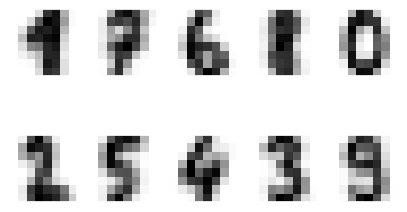

In [5]:
fig = plt.figure(figsize=(5, 3))
for i in range(10):
    ax = fig.add_subplot(2, 5, 1 + i, xticks=[], yticks=[])
    ax.imshow(kmeans.cluster_centers_[i].reshape((8, 8)), cmap=plt.cm.binary)

We see that *even without the labels*, KMeans is able to find clusters whose means are recognizable digits (with apologies to the number 8)!

The cluster labels are permuted; let's fix this:

In [6]:
labels = np.zeros_like(clusters)
for i in range(10):
    mask = (clusters == i)
    labels[mask] = mode(digits.target[mask])[0]

### PCA
Let's use our PCA visualization and look at the true cluster labels and K-means cluster labels:

/var/folders/dr/_x17x1d14k3614c36x1bhwbh0000gn/T/ipykernel_5612/4063610221.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  kwargs = dict(cmap = plt.cm.get_cmap('rainbow', 10),


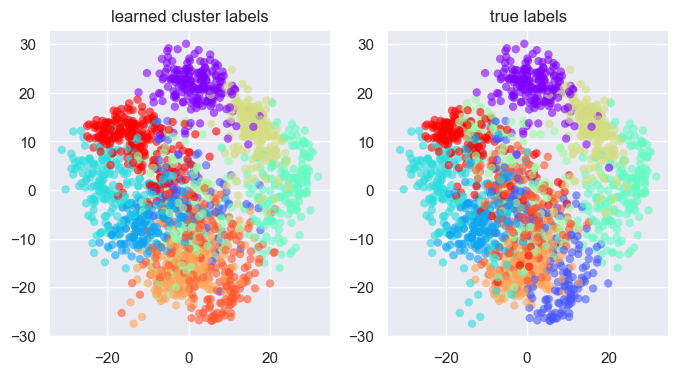

In [7]:
X = PCA(2).fit_transform(digits.data)

kwargs = dict(cmap = plt.cm.get_cmap('rainbow', 10),
              edgecolor='none', alpha=0.6)
fig, ax = plt.subplots(1, 2, figsize=(8, 4))
ax[0].scatter(X[:, 0], X[:, 1], c=labels, **kwargs)
ax[0].set_title('learned cluster labels')

ax[1].scatter(X[:, 0], X[:, 1], c=digits.target, **kwargs)
ax[1].set_title('true labels');

####  Classifier Score
Lets score a K-Means classifier is with no label information:

In [8]:
accuracy_score(digits.target, labels)

0.7941012799109627

[[177   0   0   0   1   0   0   0   0   0]
 [  0  55  24   1   0   1   2   0  99   0]
 [  1   2 148  13   0   0   0   3   8   2]
 [  0   0   1 157   0   2   0   7   7   9]
 [  0   5   0   0 164   0   0   8   4   0]
 [  0   0   0   1   2 136   1   0   0  42]
 [  1   1   0   0   0   0 177   0   2   0]
 [  0   2   0   0   0   1   0 174   2   0]
 [  0   6   3   3   0   6   2   3 100  51]
 [  0  20   0   6   0   7   0   7   1 139]]


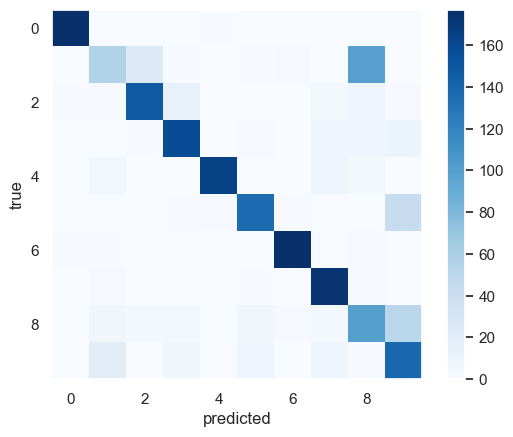

In [9]:
print(confusion_matrix(digits.target, labels))

plt.imshow(confusion_matrix(digits.target, labels),
           cmap='Blues', interpolation='nearest')
plt.colorbar()
plt.grid(False)
plt.ylabel('true')
plt.xlabel('predicted');

80% classification accuracy for an **entirely unsupervised estimator** which knew nothing about the labels.

## Image Compression

Vector Quantization with K-Means for Image Compression:

Given an image with millions of pixels, we want to reduce the number of unique colors in the image while preserving its visual quality.

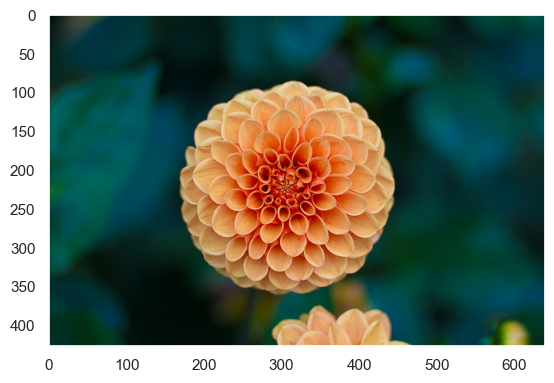

In [10]:
from sklearn.datasets import load_sample_image
flower = load_sample_image("flower.jpg")
plt.imshow(flower)
plt.grid(False);

The image itself is stored in a 3-dimensional array, of size ``(height, width, RGB)``:

In [11]:
flower.shape

(427, 640, 3)

We can envision this image as a cloud of points in a 3-dimensional color space. We'll rescale the colors so they lie between 0 and 1, then reshape the array to be a typical scikit-learn input:

In [12]:
X = (flower / 255.0).reshape(-1, 3)
print(X.shape)

(273280, 3)


We now have 273,280 points in 3 dimensions.

Our task is to use KMeans to compress the $256^3$ colors into a smaller number (say, 64 colors). Basically, we want to find $N_{color}$ clusters in the data, and create a new image where the true input color is replaced by the color of the closest cluster.

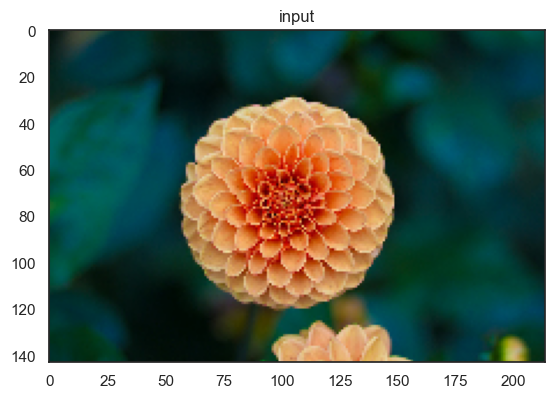

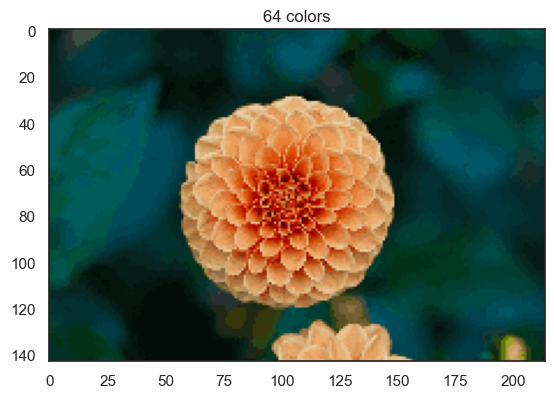

In [13]:
# reduce the size of the image for speed
image = flower[::3, ::3]
n_colors = 64

X = (image / 255.0).reshape(-1, 3)
    
model = KMeans(n_colors, n_init= 10)
labels = model.fit_predict(X)
colors = model.cluster_centers_
new_image = colors[labels].reshape(image.shape)
new_image = (255 * new_image).astype(np.uint8)

# create and plot the new image
with sns.axes_style('white'):
    plt.figure()
    plt.imshow(image)
    plt.title('input')

    plt.figure()
    plt.imshow(new_image)
    plt.title('{0} colors'.format(n_colors))

Compare the input and output image: we've reduced the $256^3$ colors to just 64.